- https://www.kaggle.com/datasets/lonnieqin/ump-combinatorialpurgedgroupkfold-tf-record

- https://www.kaggle.com/code/pythonash/end-to-end-simple-and-powerful-dnn-with-leakyrelu

# If you copy this notebook, please upvote !!

##  Market Prediction with Conv2d
It is assumed that there is a complex relationship between the features.

The relationship is clarified by spatial analysis.

LB = 0.152

Derived from Conv1d ver. The difference in performance from previous version is under verification.
### Refrence
Special thanks @Lonnie Ubiquant Market Prediction with DNN

- https://www.kaggle.com/lonnieqin/ubiquant-market-prediction-with-dnn## 

Conv1d version is here
- https://www.kaggle.com/code/shigeeeru/prediction-including-spatial-info-with-conv1d

### Note
- delete investment feature
- add random.set_seed

In [3]:
import os
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from scipy import stats
from tensorflow.python.ops import math_ops
from tensorflow.python.keras import backend as K

### add random seed
tf.random.set_seed(3)
# tf.random.set_random_seed(3)

import sys
sys.path.append('../')
from model import model_conv2D

2022-05-05 02:12:39.091866: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/amazon/efa/lib:/opt/amazon/openmpi/lib:/usr/local/lib:/usr/lib:
2022-05-05 02:12:39.091896: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Configuration

If you want to train model, change 'is_trainig' to 'True'.

In [2]:
! ls ../data/input

CombinatorialPurgedGroupKFold_tf_record
ubiquant-market-prediction-half-precision-pickle


In [4]:
class Config:
#     is_training = False
    is_training = True
    tf_record_dataset_path = "../data/input/CombinatorialPurgedGroupKFold_tf_record/"
    ### change here ###
    output_dataset_path = "../data/model_wight/dnn-base-outputs/"
config = Config()

## Create an IntegerLookup layer for investment_id input

## Make Tensorflow dataset

In [5]:
%%time
investment_ids = pd.read_csv(config.tf_record_dataset_path + "investment_ids.csv")
investment_id_size = len(investment_ids) + 1
with tf.device("cpu"):
    investment_id_lookup_layer = layers.IntegerLookup(max_tokens=investment_id_size)
    investment_id_lookup_layer.adapt(investment_ids)

CPU times: user 161 ms, sys: 17.5 ms, total: 178 ms
Wall time: 171 ms


2022-05-05 02:13:28.122173: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/amazon/efa/lib:/opt/amazon/openmpi/lib:/usr/local/lib:/usr/lib:
2022-05-05 02:13:28.122201: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-05 02:13:28.122218: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-17-131): /proc/driver/nvidia/version does not exist
2022-05-05 02:13:28.122476: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [59]:
def decode_function(record_bytes):
    return tf.io.parse_single_example(
      # Data
      record_bytes,
      # Schema
      {
          "features": tf.io.FixedLenFeature([300], dtype=tf.float32),
          "time_id": tf.io.FixedLenFeature([], dtype=tf.int64),
          "investment_id": tf.io.FixedLenFeature([], dtype=tf.int64),
          "target": tf.io.FixedLenFeature([], dtype=tf.float32)
      }
  )

# def preprocess(X, y):
#     return X, y
# def make_dataset(feature, investment_id, y, batch_size=1024, mode="train"):
#     ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature), y))
#     ds = ds.map(preprocess)
#     if mode == "train":
#         ds = ds.shuffle(4096)
#     ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
#     return ds


def preprocess(item):
    return (item["investment_id"],item["features"]), item["target"]
# def preprocess(item):
#     return (item["features"]), item["target"]
def make_dataset(file_paths, batch_size=4096, mode="train"):
    ds = tf.data.TFRecordDataset(file_paths)
    ds = ds.map(decode_function)
    ds = ds.map(preprocess)
    if mode == "train":
        ds = ds.shuffle(batch_size * 4)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    return ds

In [60]:
ts = make_dataset(f"{config.tf_record_dataset_path}fold_0_train.tfrecords")

In [61]:
ts

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None, 300), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

## Modeling

I use layers.Conv1d. 

[source is here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D)



In [62]:
def correlation(x, y, axis=-2):
    """Metric returning the Pearson correlation coefficient of two tensors over some axis, default -2."""
    x = tf.convert_to_tensor(x)
    y = math_ops.cast(y, x.dtype)
    n = tf.cast(tf.shape(x)[axis], x.dtype)
    xsum = tf.reduce_sum(x, axis=axis)
    ysum = tf.reduce_sum(y, axis=axis)
    xmean = xsum / n
    ymean = ysum / n
    ###    不偏分散にしたら？？   ###
    
    xvar = tf.reduce_sum( tf.math.squared_difference(x, xmean), axis=axis)
    yvar = tf.reduce_sum( tf.math.squared_difference(y, ymean), axis=axis)

    cov = tf.reduce_sum( (x - xmean) * (y - ymean), axis=axis)
    corr = cov / tf.sqrt(xvar * yvar)
    return tf.constant(1.0, dtype=x.dtype) - corr

def get_model():
    investment_id_inputs = tf.keras.Input((1, ), dtype=tf.uint16)
    features_inputs = tf.keras.Input((300, ), dtype=tf.float16)
    
    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    investment_id_x = layers.Embedding(investment_id_size, 32, input_length=1)(investment_id_x)
    investment_id_x = layers.Reshape((-1, ))(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    
    feature_x = layers.Dense(256, activation='swish')(features_inputs)
    feature_x = layers.Dense(256, activation='swish')(feature_x)
    feature_x = layers.Dense(256, activation='swish')(feature_x)
    
    x = layers.Concatenate(axis=1)([investment_id_x, feature_x])
    x = layers.Dense(512, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dense(128, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dense(32, activation='swish', kernel_regularizer="l2")(x)
    output = layers.Dense(1)(x)
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")
    model = tf.keras.Model(inputs=[investment_id_inputs, features_inputs], outputs=[output])
    model.compile(optimizer=tf.optimizers.Adam(0.001), loss='mse', metrics=['mse', "mae", "mape", rmse, correlation])
    return model


# def get_model():
#     features_inputs = tf.keras.Input((300, ), dtype=tf.float16)
    
#     ## Dense 1 ##
#     feature_x = layers.Dense(256, activation='swish', kernel_initializer = 'he_normal')(features_inputs)
#     feature_x = layers.Dropout(0.1)(feature_x)
# #     ## Dense 2 ##
# #     feature_x = layers.Dense(256, activation='swish')(feature_x)
# #     feature_x = layers.Dropout(0.1)(feature_x)
#     ## convolution 1 ##
#     feature_x = layers.Reshape((-1,1))(feature_x)
#     feature_x = layers.Conv1D(filters=16, kernel_size=4, strides=1, padding='same', kernel_initializer = 'he_normal')(feature_x)
#     feature_x = layers.BatchNormalization()(feature_x)
#     feature_x = layers.LeakyReLU(0.5)(feature_x)
#     ## convolution 2 ##
#     feature_x = layers.Conv1D(filters=16, kernel_size=4, strides=4, padding='same', kernel_initializer = 'he_normal')(feature_x)
#     feature_x = layers.BatchNormalization()(feature_x)
#     feature_x = layers.LeakyReLU(0.5)(feature_x)
#     ## convolution 3 ##
#     feature_x = layers.Conv1D(filters=64, kernel_size=4, strides=1, padding='same', kernel_initializer = 'he_normal')(feature_x)
#     feature_x = layers.BatchNormalization()(feature_x)
#     feature_x = layers.LeakyReLU(0.5)(feature_x)

#     ## convolution2D 1 ##
#     feature_x = layers.Reshape((64,64,1))(feature_x)
#     feature_x = layers.Conv2D(filters=32, kernel_size=4, strides=1, padding='same', kernel_initializer = 'he_normal')(feature_x)
#     feature_x = layers.BatchNormalization()(feature_x)
#     feature_x = layers.LeakyReLU(0.5)(feature_x)
#     ## convolution2D 2 ##
#     feature_x = layers.Conv2D(filters=32, kernel_size=4, strides=4, padding='same', kernel_initializer = 'he_normal')(feature_x)
#     feature_x = layers.BatchNormalization()(feature_x)
#     feature_x = layers.LeakyReLU(0.5)(feature_x)
#     ## convolution2D 3 ##
#     feature_x = layers.Conv2D(filters=32, kernel_size=4, strides=4, padding='same', kernel_initializer = 'he_normal')(feature_x)
#     feature_x = layers.BatchNormalization()(feature_x)
#     feature_x = layers.LeakyReLU(0.5)(feature_x)

#     ## flatten ##
#     feature_x = layers.Flatten()(feature_x)
#     ## Dense 3 ##
#     x = layers.Dense(512, activation='swish', kernel_regularizer="l2", kernel_initializer = 'he_normal')(feature_x)
#     ## Dense 4 ##
#     x = layers.Dropout(0.1)(x)
#     ## Dense 5 ##    
#     x = layers.Dense(128, activation='swish', kernel_regularizer="l2", kernel_initializer = 'he_normal')(x)
#     x = layers.Dropout(0.1)(x)
#     ## Dense 6 ##
#     x = layers.Dense(32, activation='swish', kernel_regularizer="l2", kernel_initializer = 'he_normal')(x)
#     x = layers.Dropout(0.1)(x)
#     ## Dense 7 ##
#     output = layers.Dense(1)(x)
#     rmse = keras.metrics.RootMeanSquaredError(name="rmse")
#     model = tf.keras.Model(inputs=[features_inputs], outputs=[output])
    
#     learning_sch = tf.keras.optimizers.schedules.ExponentialDecay(
#         initial_learning_rate = 0.001,
#         decay_steps = 9700,
#         decay_rate = 0.98
#     )
#     adam = tf.keras.optimizers.Adam(learning_rate = learning_sch)
    
#     model.compile(optimizer = adam, loss='mse', metrics=['mse', "mae", "mape", rmse, correlation])
#     return model

Let's take a look at this Model's architecture.

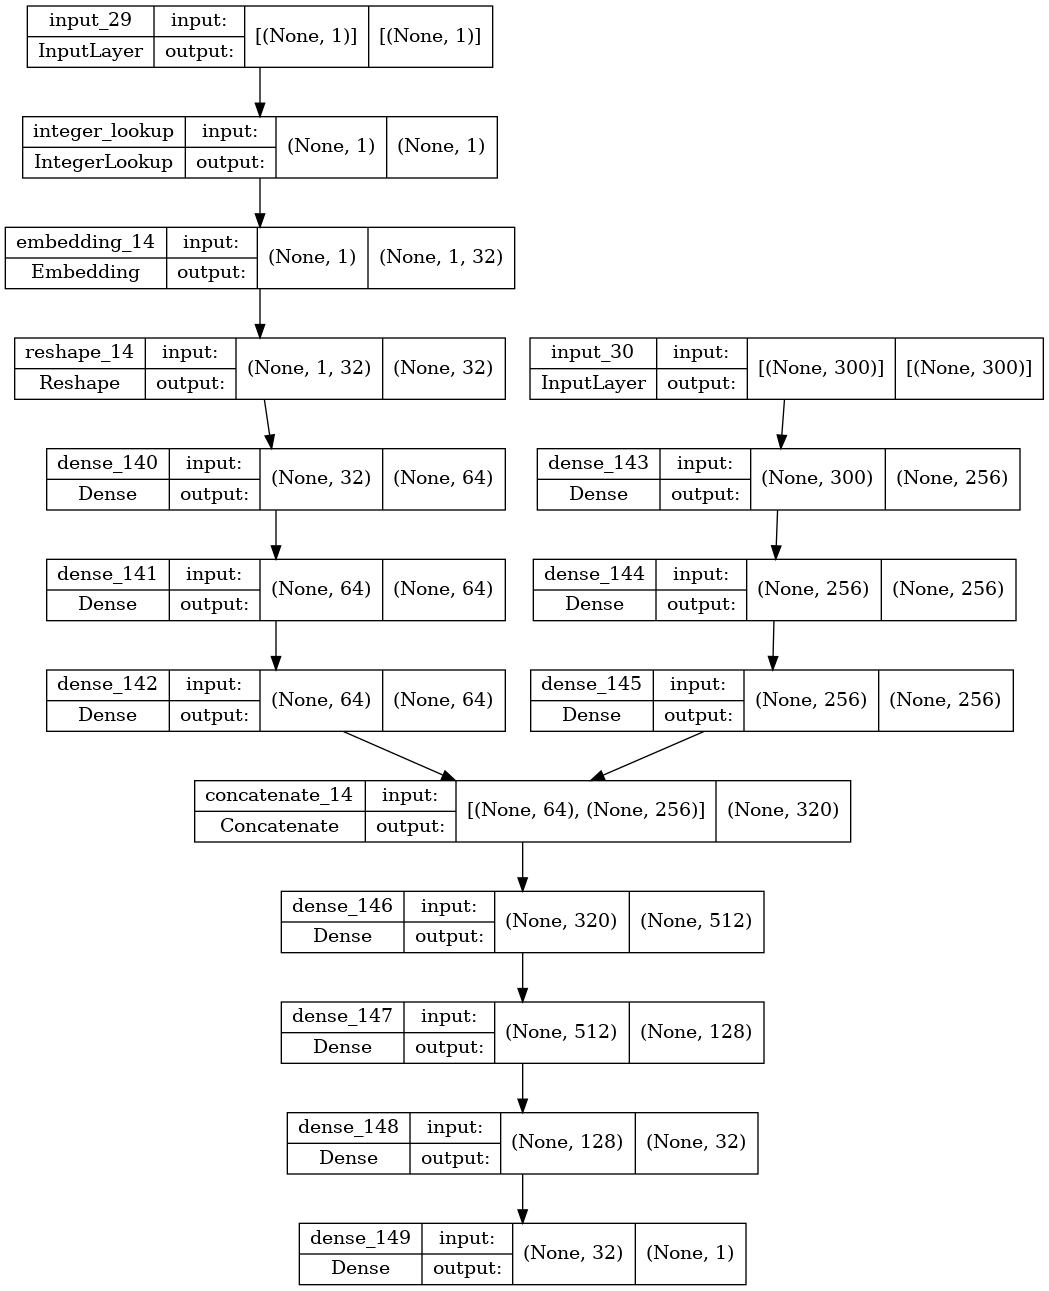

In [63]:
model = get_model()
# model.summary()
keras.utils.plot_model(model, show_shapes=True)

## Model Training

In [ ]:
%%time
models = []
for i in range(5):
    train_path = f"{config.tf_record_dataset_path}fold_{i}_train.tfrecords"
    valid_path = f"{config.tf_record_dataset_path}fold_{i}_test.tfrecords"
    
#     valid_ds = make_dataset(X_val, investment_id_val, y_val, mode="valid")
    valid_ds = make_dataset([valid_path], mode="valid")
    print(valid_ds)
    model = get_model()
    if config.is_training:
        train_ds = make_dataset([train_path])
        
        checkpoint = keras.callbacks.ModelCheckpoint(f"model_{i}.tf", monitor="val_correlation", mode="min", save_best_only=True, save_weights_only=True)
        early_stop = keras.callbacks.EarlyStopping(patience=10)
        history = model.fit(train_ds, epochs=50, validation_data=valid_ds, callbacks=[checkpoint, early_stop])
        model.save_weights(f"model_{i}.tf")
        for metric in ["loss", "mae", "mape", "rmse", "correlation"]:
            pd.DataFrame(history.history, columns=[metric, f"val_{metric}"]).plot()
            plt.title(metric.upper())
            plt.show()
    else:
        model.load_weights(f"{config.output_dataset_path}model_{i}.tf")
    y_vals = []
    for _, y in valid_ds:
        y_vals += list(y.numpy().reshape(-1))
    y_val = np.array(y_vals)
    pearson_score = stats.pearsonr(model.predict(valid_ds).reshape(-1), y_val)[0]
    models.append(model)
    print(f"Pearson Score: {pearson_score}")


<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None, 300), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>
Epoch 1/50
627/627 [==============================] - 219s 346ms/step - loss: 1.1212 - mse: 0.8274 - mae: 0.6220 - mape: 137067.2344 - rmse: 0.9096 - correlation: 0.8716 - val_loss: 0.8664 - val_mse: 0.8647 - val_mae: 0.6443 - val_mape: 113052.9688 - val_rmse: 0.9299 - val_correlation: 0.9207
Epoch 2/50
627/627 [==============================] - 64s 102ms/step - loss: 0.8252 - mse: 0.8230 - mae: 0.6204 - mape: 154061.7969 - rmse: 0.9072 - correlation: 0.8552 - val_loss: 0.8642 - val_mse: 0.8629 - val_mae: 0.6441 - val_mape: 112303.6406 - val_rmse: 0.9289 - val_correlation: 0.9134
Epoch 3/50
627/627 [==============================] - 64s 102ms/step - loss: 0.8230 - mse: 0.8207 - mae: 0.6197 - mape: 162698.7031 - rmse: 0.9059 - correlation: 0.8463 - val_loss: 0.8635 - val_mse: 0.8623 - v

## Submission

In [ ]:
# def preprocess_test(investment_id, feature):
#     return (investment_id, feature), 0

# def make_test_dataset(feature, investment_id, batch_size=1024):
#     ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature)))
#     ds = ds.map(preprocess_test)
#     ds = ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
#     return ds

def make_test_dataset(feature, batch_size=1024):
    ds = tf.data.Dataset.from_tensor_slices(((feature)))
    ds = ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    return ds

def inference(models, ds):
    y_preds = []
    for model in models:
        y_pred = model.predict(ds)
        y_preds.append(y_pred)
    return np.mean(y_preds, axis=0)

In [ ]:
import ubiquant
env = ubiquant.make_env()
iter_test = env.iter_test() 
features = [f"f_{i}" for i in range(300)]
for (test_df, sample_prediction_df) in iter_test:
    ds = make_test_dataset(test_df[features])
    sample_prediction_df['target'] = inference(models, ds)
    env.predict(sample_prediction_df)     
    